In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = "/content/drive/MyDrive/brain_dataset/"
SEED = 40

In [4]:
os.listdir(MAIN_DIR)

['yes', 'no']

In [5]:
for dirpath,dirnames,filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

2 directories and 0 images in /content/drive/MyDrive/brain_dataset/
0 directories and 155 images in /content/drive/MyDrive/brain_dataset/yes
0 directories and 98 images in /content/drive/MyDrive/brain_dataset/no


In [6]:
def view_random_image():

    subdirs = ['yes/','no/']
    subdir = np.random.choice(subdirs)
    target_folder = MAIN_DIR + subdir

    random_image = random.sample(os.listdir(target_folder), 1)

    img = cv2.imread(target_folder+random_image[0])
    plt.imshow(img, cmap="gray")
    plt.axis(False)
    plt.title(img.shape)
    plt.show()

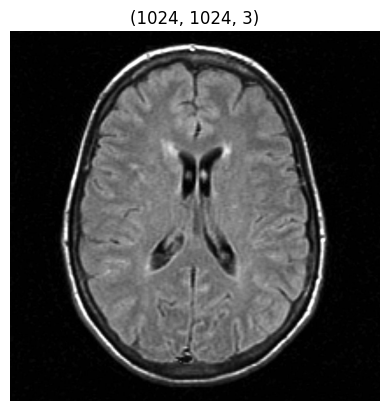

In [7]:
view_random_image()

In [8]:
IMG_SHAPE = (128,128)
BATCH_SIZE = 32

In [9]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.5)
train_data = datagen.flow_from_directory(MAIN_DIR,
                                        target_size=IMG_SHAPE,
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        shuffle=True,
                                        subset="training")

test_data = datagen.flow_from_directory(MAIN_DIR,
                                       target_size=IMG_SHAPE,
                                       batch_size=BATCH_SIZE,
                                       class_mode="binary",
                                       shuffle=True,
                                       subset="validation")

Found 127 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [10]:
len(train_data), len(test_data)

(4, 4)

In [11]:
tf.random.set_seed(SEED)

model = Sequential([
    Conv2D(filters=64,
           kernel_size=3,
           activation='relu'),
    Conv2D(32,3,activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(32,3,activation='relu'),
    Conv2D(16,3,activation='relu'),
    MaxPool2D(2, padding='same'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/10
4/4 [==============================] - 35s 8s/step - loss: 0.6663 - accuracy: 0.6063 - val_loss: 0.5996 - val_accuracy: 0.6111
Epoch 2/10
4/4 [==============================] - 19s 5s/step - loss: 0.5811 - accuracy: 0.6614 - val_loss: 0.5205 - val_accuracy: 0.7698
Epoch 3/10
4/4 [==============================] - 21s 6s/step - loss: 0.5261 - accuracy: 0.7559 - val_loss: 0.5166 - val_accuracy: 0.8016
Epoch 4/10
4/4 [==============================] - 23s 6s/step - loss: 0.4941 - accuracy: 0.7559 - val_loss: 0.4832 - val_accuracy: 0.7698
Epoch 5/10
4/4 [==============================] - 20s 5s/step - loss: 0.4521 - accuracy: 0.8031 - val_loss: 0.4709 - val_accuracy: 0.7937
Epoch 6/10
4/4 [==============================] - 18s 5s/step - loss: 0.3945 - accuracy: 0.8346 - val_loss: 0.4822 - val_accuracy: 0.7619
Epoch 7/10
4/4 [==============================] - 17s 5s/step - loss: 0.3549 - accuracy: 0.8346 - val_loss: 0.5043 - val_accuracy: 0.7698
Epoch 8/10
4/4 [==================

In [12]:
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """
    import matplotlib.pyplot as plt

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

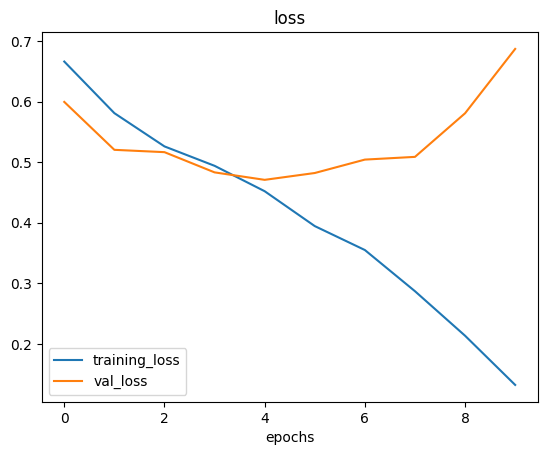

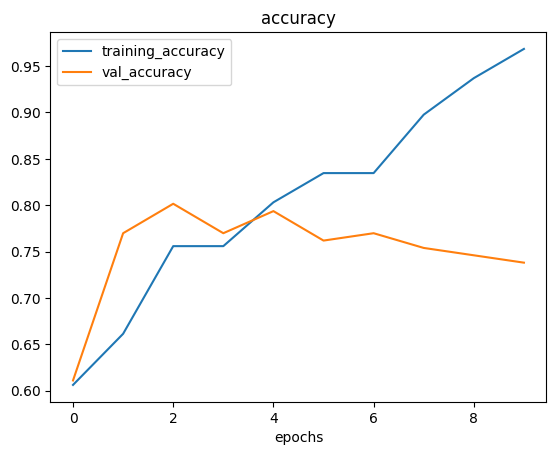

In [13]:
plot_curves(history)

In [14]:
result = model.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 73.81%
Loss: 0.6871


In [15]:
effnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Feature Layer
effnet_layer = hub.KerasLayer(effnet_url,
                              trainable=False,
                              name="feature_extraction_layer")

# Create Sequential model
effnet_model = Sequential([
    effnet_layer,
    Dense(1, activation="sigmoid")
])

# Compile the model
effnet_model.compile(loss=BinaryCrossentropy(),
                     optimizer=Adam(),
                     metrics=["accuracy"])

# Fit the model
effnet_history = effnet_model.fit(train_data,
                                  epochs=10,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/10
4/4 [==============================] - 22s 3s/step - loss: 0.7623 - accuracy: 0.4961 - val_loss: 0.7526 - val_accuracy: 0.5079
Epoch 2/10
4/4 [==============================] - 6s 2s/step - loss: 0.6948 - accuracy: 0.5433 - val_loss: 0.7020 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 0.6387 - accuracy: 0.5984 - val_loss: 0.6561 - val_accuracy: 0.5952
Epoch 4/10
4/4 [==============================] - 8s 2s/step - loss: 0.5916 - accuracy: 0.6850 - val_loss: 0.6144 - val_accuracy: 0.6825
Epoch 5/10
4/4 [==============================] - 9s 3s/step - loss: 0.5531 - accuracy: 0.7559 - val_loss: 0.5765 - val_accuracy: 0.7302
Epoch 6/10
4/4 [==============================] - 8s 3s/step - loss: 0.5168 - accuracy: 0.7953 - val_loss: 0.5450 - val_accuracy: 0.7857
Epoch 7/10
4/4 [==============================] - 8s 2s/step - loss: 0.4843 - accuracy: 0.8268 - val_loss: 0.5197 - val_accuracy: 0.8175
Epoch 8/10
4/4 [========================

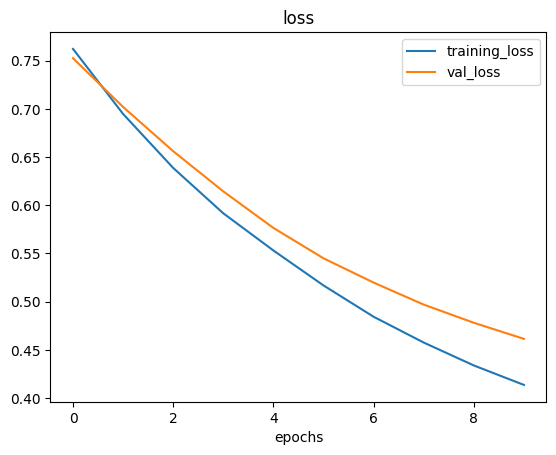

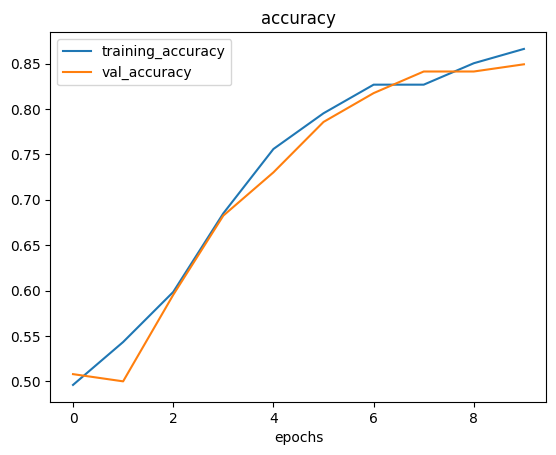

In [16]:
plot_curves(effnet_history)

In [17]:
result = effnet_model.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 84.92%
Loss: 0.4613
